# Set Parameter
- Attention = Luong
- Teacher Forcing Ratio = 0.5
- Layer = 1
- Batch size = 32
- Drop out = 0.2
- Hidden unit = [2, 50, 4]
- Epochs = 100
- N = 100
- Data = 10K
- Deduplication & Random Split

# Import packages

import useful packages for experiments

In [1]:
import os
import argparse
import logging

import torch
from torch.optim.lr_scheduler import StepLR
import torchtext

from trainer.supervised_trainer import SupervisedTrainer
from models.encoderRNN import EncoderRNN
from models.decoderRNN import DecoderRNN
from models.seq2seq import Seq2seq
from loss.loss import Perplexity
from optim.optim import Optimizer
from dataset import fields
from evaluator.predictor import Predictor

import matplotlib.pyplot as plt

/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))
/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


# Log format

In [2]:
log_level = 'info'
LOG_FORMAT = '%(asctime)s %(levelname)-6s %(message)s'
logging.basicConfig(format=LOG_FORMAT, level=getattr(logging, log_level.upper()))

# Data load

In [3]:
train_path = "data/bracket_rand/N100/data_train.txt"
dev_path = "data/bracket_rand/N100/data_test.txt"

# Prepare dataset

In [4]:
src = fields.SourceField()
tgt = fields.TargetField()
max_len = 104
def len_filter(example):
    return len(example.src) <= max_len and len(example.tgt) <= max_len
train = torchtext.data.TabularDataset(
    path=train_path, format='tsv',
    fields=[('src', src), ('tgt', tgt)],
    filter_pred=len_filter
)
dev = torchtext.data.TabularDataset(
    path=dev_path, format='tsv',
    fields=[('src', src), ('tgt', tgt)],
    filter_pred=len_filter
)
src.build_vocab(train)
tgt.build_vocab(train)
input_vocab = src.vocab
output_vocab = tgt.vocab

# Prepare loss

In [5]:
weight = torch.ones(len(tgt.vocab))
pad = tgt.vocab.stoi[tgt.pad_token]
loss = Perplexity(weight, pad)
if torch.cuda.is_available():
    loss.cuda()

/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


# Variable definition

In [ ]:
optimizer = "Adam"
hidden_sizes = list(range(2, 51, 4))
character_error_rate = []
sentance_error_rate = []
bidirectional = True
print(hidden_sizes)

[2, 6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50]


In [ ]:
for i in hidden_sizes:
    hidden_size = i
    print("hidden size is : %d" % hidden_size)
    seq2seq = None
    encoder = EncoderRNN(len(src.vocab), max_len, hidden_size,
                         bidirectional=bidirectional, variable_lengths=True)
    decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                         dropout_p=0.2, use_attention="Luong", bidirectional=bidirectional,
                         eos_id=tgt.eos_id, sos_id=tgt.sos_id)
    seq2seq = Seq2seq(encoder, decoder)
    if torch.cuda.is_available():
        seq2seq.cuda()

    for param in seq2seq.parameters():
        param.data.uniform_(-0.08, 0.08)

    # train
    t = SupervisedTrainer(loss=loss, batch_size=32,
                          checkpoint_every=50,
                          print_every=100,
                          hidden_size=hidden_size,
                          path="hidden_size_to_error_rate/rand_Hidden_" + str(hidden_size))

    seq2seq, ave_loss, character_accuracy_list, sentance_accuracy_list = t.train(seq2seq, train,
                                                                                num_epochs=100, dev_data=dev,
                                                                                optimizer=optimizer,
                                                                                teacher_forcing_ratio=0.5)
    
    best_character_accuracy = 0
    best_sentance_accuracy = 0
    for i,j in zip(character_accuracy_list, sentance_accuracy_list):
        if best_character_accuracy < i:
            best_character_accuracy = i
        if best_sentance_accuracy < j:
            best_sentance_accuracy = j

    character_error_rate.append(1 - best_character_accuracy)
    sentance_error_rate.append(1 - best_sentance_accuracy)

/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
2019-02-27 11:19:56,522 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


hidden size is : 2


/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
2019-02-27 11:20:53,418 INFO   Finished epoch 1: Train loss: 33.8840, Dev loss: 24.4351, Accuracy(Character): 0.0704, Accuracy(Word): 0.0000
2019-02-27 11:21:50,225 INFO   Finished epoch 2: Train loss: 21.7157, Dev loss: 21.1016, Accuracy(Character): 0.0730, Accuracy(Word): 0.0000
2019-02-27 11:22:46,059 INFO   Finished epoch 3: Train loss: 20.2787, Dev loss: 20.5533, Accuracy(Character): 0.0752, Accuracy(Word): 0.0000
2019-02-27 11:23:43,880 INFO   Finished epoch 4: Train loss: 19.4647, Dev loss: 20.4731, Accuracy(Character): 0.0758, Accuracy(Word): 0.0000
2019-02-27 11:24:43,630 INFO   Finished epoch 5: Train loss: 18.8236, Dev loss: 20.7200, Accuracy(Character): 0.0752, Accuracy(Word): 0.0000
2019-02-27 11:25:41,828 INFO   Finished epoch 6: Train loss: 1

2019-02-27 12:17:39,267 INFO   Finished epoch 58: Train loss: 15.7422, Dev loss: 22.9922, Accuracy(Character): 0.1247, Accuracy(Word): 0.0000
2019-02-27 12:19:10,148 INFO   Finished epoch 59: Train loss: 13.0012, Dev loss: 19.8811, Accuracy(Character): 0.1296, Accuracy(Word): 0.0000
2019-02-27 12:20:43,022 INFO   Finished epoch 60: Train loss: 13.9263, Dev loss: 20.8110, Accuracy(Character): 0.1249, Accuracy(Word): 0.0000
2019-02-27 12:22:13,707 INFO   Finished epoch 61: Train loss: 12.9100, Dev loss: 21.1986, Accuracy(Character): 0.1210, Accuracy(Word): 0.0000
2019-02-27 12:23:44,943 INFO   Finished epoch 62: Train loss: 11.8848, Dev loss: 21.4363, Accuracy(Character): 0.1223, Accuracy(Word): 0.0000
2019-02-27 12:25:14,632 INFO   Finished epoch 63: Train loss: 13.2356, Dev loss: 23.9552, Accuracy(Character): 0.1224, Accuracy(Word): 0.0000
2019-02-27 12:26:48,247 INFO   Finished epoch 64: Train loss: 13.6440, Dev loss: 22.9583, Accuracy(Character): 0.1163, Accuracy(Word): 0.0000
2019-0

hidden size is : 6


2019-02-27 13:23:48,409 INFO   Finished epoch 1: Train loss: 28.4042, Dev loss: 20.6105, Accuracy(Character): 0.0730, Accuracy(Word): 0.0000
2019-02-27 13:25:21,121 INFO   Finished epoch 2: Train loss: 19.9315, Dev loss: 20.2248, Accuracy(Character): 0.0730, Accuracy(Word): 0.0000
2019-02-27 13:26:52,242 INFO   Finished epoch 3: Train loss: 19.7000, Dev loss: 20.1087, Accuracy(Character): 0.0730, Accuracy(Word): 0.0000
2019-02-27 13:28:26,329 INFO   Finished epoch 4: Train loss: 19.6349, Dev loss: 20.1075, Accuracy(Character): 0.0752, Accuracy(Word): 0.0000
2019-02-27 13:29:59,045 INFO   Finished epoch 5: Train loss: 19.6055, Dev loss: 20.0375, Accuracy(Character): 0.0750, Accuracy(Word): 0.0000
2019-02-27 13:31:37,130 INFO   Finished epoch 6: Train loss: 19.4766, Dev loss: 19.8077, Accuracy(Character): 0.0890, Accuracy(Word): 0.0000
2019-02-27 13:33:11,757 INFO   Finished epoch 7: Train loss: 18.9337, Dev loss: 19.3077, Accuracy(Character): 0.0882, Accuracy(Word): 0.0000
2019-02-27 13

2019-02-27 14:52:46,399 INFO   Finished epoch 59: Train loss: 25.7711, Dev loss: 34.0832, Accuracy(Character): 0.1571, Accuracy(Word): 0.0098
2019-02-27 14:54:08,776 INFO   Finished epoch 60: Train loss: 17.9563, Dev loss: 21.7645, Accuracy(Character): 0.1743, Accuracy(Word): 0.0086
2019-02-27 14:55:29,189 INFO   Finished epoch 61: Train loss: 14.9787, Dev loss: 21.2018, Accuracy(Character): 0.1762, Accuracy(Word): 0.0088
2019-02-27 14:56:58,005 INFO   Finished epoch 62: Train loss: 11.8868, Dev loss: 18.2074, Accuracy(Character): 0.1734, Accuracy(Word): 0.0118
2019-02-27 14:58:24,900 INFO   Finished epoch 63: Train loss: 16.3364, Dev loss: 36.2906, Accuracy(Character): 0.1633, Accuracy(Word): 0.0098
2019-02-27 14:59:50,897 INFO   Finished epoch 64: Train loss: 18.7628, Dev loss: 35.2926, Accuracy(Character): 0.1491, Accuracy(Word): 0.0130
2019-02-27 15:01:13,912 INFO   Finished epoch 65: Train loss: 13.7983, Dev loss: 17.4910, Accuracy(Character): 0.1707, Accuracy(Word): 0.0140
2019-0

hidden size is : 10


2019-02-27 15:57:29,623 INFO   Finished epoch 1: Train loss: 26.7024, Dev loss: 20.2632, Accuracy(Character): 0.0792, Accuracy(Word): 0.0000
2019-02-27 15:59:04,556 INFO   Finished epoch 2: Train loss: 19.7106, Dev loss: 19.9656, Accuracy(Character): 0.1007, Accuracy(Word): 0.0000
2019-02-27 16:00:38,267 INFO   Finished epoch 3: Train loss: 19.0046, Dev loss: 19.0661, Accuracy(Character): 0.0872, Accuracy(Word): 0.0000
2019-02-27 16:02:15,428 INFO   Finished epoch 4: Train loss: 17.7551, Dev loss: 18.4525, Accuracy(Character): 0.0969, Accuracy(Word): 0.0000
2019-02-27 16:03:48,088 INFO   Finished epoch 5: Train loss: 17.0354, Dev loss: 18.7050, Accuracy(Character): 0.0877, Accuracy(Word): 0.0000
2019-02-27 16:05:25,818 INFO   Finished epoch 6: Train loss: 16.2248, Dev loss: 20.1508, Accuracy(Character): 0.0829, Accuracy(Word): 0.0000
2019-02-27 16:07:02,028 INFO   Finished epoch 7: Train loss: 15.5913, Dev loss: 20.2124, Accuracy(Character): 0.0877, Accuracy(Word): 0.0000
2019-02-27 16

2019-02-27 17:30:21,207 INFO   Finished epoch 59: Train loss: 18.6876, Dev loss: 32.4194, Accuracy(Character): 0.2673, Accuracy(Word): 0.0224
2019-02-27 17:31:59,114 INFO   Finished epoch 60: Train loss: 21.1322, Dev loss: 12.6452, Accuracy(Character): 0.2924, Accuracy(Word): 0.0288
2019-02-27 17:33:32,685 INFO   Finished epoch 61: Train loss: 10.8084, Dev loss: 11.5422, Accuracy(Character): 0.2996, Accuracy(Word): 0.0170
2019-02-27 17:35:03,777 INFO   Finished epoch 62: Train loss: 9.6445, Dev loss: 13.3696, Accuracy(Character): 0.3021, Accuracy(Word): 0.0238
2019-02-27 17:36:37,803 INFO   Finished epoch 63: Train loss: 8.8782, Dev loss: 12.2727, Accuracy(Character): 0.2939, Accuracy(Word): 0.0192
2019-02-27 17:38:13,407 INFO   Finished epoch 64: Train loss: 7.9692, Dev loss: 12.1333, Accuracy(Character): 0.2989, Accuracy(Word): 0.0278
2019-02-27 17:39:47,036 INFO   Finished epoch 65: Train loss: 8.3306, Dev loss: 9.1648, Accuracy(Character): 0.3276, Accuracy(Word): 0.0172
2019-02-27 

hidden size is : 14


2019-02-27 18:35:40,049 INFO   Finished epoch 1: Train loss: 25.3365, Dev loss: 19.9176, Accuracy(Character): 0.0921, Accuracy(Word): 0.0000
2019-02-27 18:37:13,692 INFO   Finished epoch 2: Train loss: 18.2250, Dev loss: 18.4653, Accuracy(Character): 0.0939, Accuracy(Word): 0.0000
2019-02-27 18:38:47,545 INFO   Finished epoch 3: Train loss: 17.0857, Dev loss: 17.9990, Accuracy(Character): 0.0882, Accuracy(Word): 0.0000
2019-02-27 18:40:18,297 INFO   Finished epoch 4: Train loss: 16.7123, Dev loss: 23.0594, Accuracy(Character): 0.0797, Accuracy(Word): 0.0000
2019-02-27 18:41:50,530 INFO   Finished epoch 5: Train loss: 16.7297, Dev loss: 30.0602, Accuracy(Character): 0.0805, Accuracy(Word): 0.0000
2019-02-27 18:43:23,087 INFO   Finished epoch 6: Train loss: 15.8551, Dev loss: 38.3851, Accuracy(Character): 0.0816, Accuracy(Word): 0.0000
2019-02-27 18:44:55,060 INFO   Finished epoch 7: Train loss: 16.8666, Dev loss: 18.4682, Accuracy(Character): 0.1051, Accuracy(Word): 0.0000
2019-02-27 18

2019-02-27 20:06:27,278 INFO   Finished epoch 60: Train loss: 2.8896, Dev loss: 4.5816, Accuracy(Character): 0.4413, Accuracy(Word): 0.0744
2019-02-27 20:07:57,216 INFO   Finished epoch 61: Train loss: 2.8421, Dev loss: 4.1722, Accuracy(Character): 0.4547, Accuracy(Word): 0.0752
2019-02-27 20:09:26,246 INFO   Finished epoch 62: Train loss: 2.8353, Dev loss: 4.3940, Accuracy(Character): 0.4293, Accuracy(Word): 0.0608
2019-02-27 20:10:59,824 INFO   Finished epoch 63: Train loss: 2.9932, Dev loss: 4.5016, Accuracy(Character): 0.4484, Accuracy(Word): 0.0444
2019-02-27 20:12:29,990 INFO   Finished epoch 64: Train loss: 2.9420, Dev loss: 3.9960, Accuracy(Character): 0.4621, Accuracy(Word): 0.0758
2019-02-27 20:13:55,272 INFO   Finished epoch 65: Train loss: 2.9784, Dev loss: 3.7421, Accuracy(Character): 0.4787, Accuracy(Word): 0.0670
2019-02-27 20:15:15,363 INFO   Finished epoch 66: Train loss: 2.7944, Dev loss: 4.3932, Accuracy(Character): 0.4488, Accuracy(Word): 0.0812
2019-02-27 20:16:35,

hidden size is : 18


2019-02-27 20:59:18,467 INFO   Finished epoch 1: Train loss: 24.3597, Dev loss: 20.0257, Accuracy(Character): 0.1023, Accuracy(Word): 0.0000
2019-02-27 21:00:32,817 INFO   Finished epoch 2: Train loss: 18.6363, Dev loss: 18.4903, Accuracy(Character): 0.0963, Accuracy(Word): 0.0000
2019-02-27 21:01:50,331 INFO   Finished epoch 3: Train loss: 17.1306, Dev loss: 17.9041, Accuracy(Character): 0.0966, Accuracy(Word): 0.0000
2019-02-27 21:02:57,508 INFO   Finished epoch 4: Train loss: 16.4839, Dev loss: 24.0796, Accuracy(Character): 0.0891, Accuracy(Word): 0.0000
2019-02-27 21:04:09,345 INFO   Finished epoch 5: Train loss: 15.9816, Dev loss: 23.1821, Accuracy(Character): 0.0875, Accuracy(Word): 0.0000
2019-02-27 21:05:28,707 INFO   Finished epoch 6: Train loss: 14.7000, Dev loss: 18.0927, Accuracy(Character): 0.1004, Accuracy(Word): 0.0000
2019-02-27 21:06:37,070 INFO   Finished epoch 7: Train loss: 13.3421, Dev loss: 23.8816, Accuracy(Character): 0.1073, Accuracy(Word): 0.0000
2019-02-27 21

2019-02-27 22:07:01,125 INFO   Finished epoch 60: Train loss: 2.7023, Dev loss: 3.6334, Accuracy(Character): 0.4991, Accuracy(Word): 0.0828
2019-02-27 22:07:58,664 INFO   Finished epoch 61: Train loss: 2.7197, Dev loss: 3.8192, Accuracy(Character): 0.4899, Accuracy(Word): 0.0578
2019-02-27 22:08:54,723 INFO   Finished epoch 62: Train loss: 2.5488, Dev loss: 3.8303, Accuracy(Character): 0.4913, Accuracy(Word): 0.0888
2019-02-27 22:09:50,792 INFO   Finished epoch 63: Train loss: 2.7162, Dev loss: 3.8631, Accuracy(Character): 0.5048, Accuracy(Word): 0.0910
2019-02-27 22:10:47,819 INFO   Finished epoch 64: Train loss: 2.5385, Dev loss: 3.9922, Accuracy(Character): 0.4831, Accuracy(Word): 0.0846
2019-02-27 22:11:45,108 INFO   Finished epoch 65: Train loss: 3.0082, Dev loss: 3.5246, Accuracy(Character): 0.5174, Accuracy(Word): 0.0960
2019-02-27 22:12:41,737 INFO   Finished epoch 66: Train loss: 2.5638, Dev loss: 4.0289, Accuracy(Character): 0.4763, Accuracy(Word): 0.0672
2019-02-27 22:13:39,

hidden size is : 22


2019-02-27 22:46:25,345 INFO   Finished epoch 1: Train loss: 23.7921, Dev loss: 19.5240, Accuracy(Character): 0.0945, Accuracy(Word): 0.0000
2019-02-27 22:47:24,374 INFO   Finished epoch 2: Train loss: 17.7442, Dev loss: 18.0993, Accuracy(Character): 0.0918, Accuracy(Word): 0.0000
2019-02-27 22:48:29,351 INFO   Finished epoch 3: Train loss: 16.5207, Dev loss: 17.2307, Accuracy(Character): 0.1008, Accuracy(Word): 0.0000
2019-02-27 22:49:21,037 INFO   Finished epoch 4: Train loss: 15.7549, Dev loss: 17.5137, Accuracy(Character): 0.0971, Accuracy(Word): 0.0000
2019-02-27 22:50:20,428 INFO   Finished epoch 5: Train loss: 14.3092, Dev loss: 16.1229, Accuracy(Character): 0.1208, Accuracy(Word): 0.0000
2019-02-27 22:51:15,406 INFO   Finished epoch 6: Train loss: 13.9320, Dev loss: 16.9550, Accuracy(Character): 0.1266, Accuracy(Word): 0.0000
2019-02-27 22:52:15,703 INFO   Finished epoch 7: Train loss: 13.4960, Dev loss: 40.2472, Accuracy(Character): 0.0913, Accuracy(Word): 0.0000
2019-02-27 22

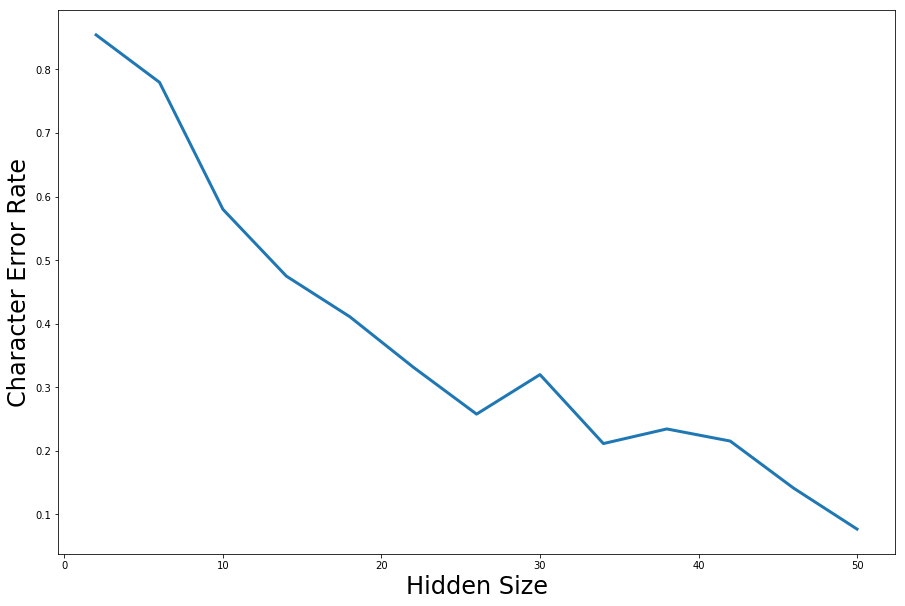

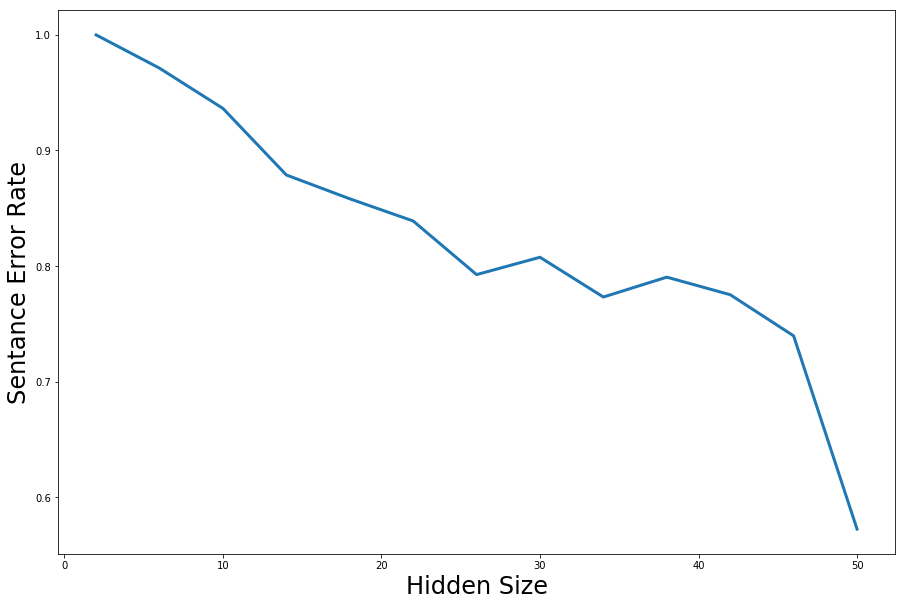

In [12]:
plt.figure(figsize=(15,10))
plt.plot(hidden_sizes, character_error_rate, LineWidth=3)
plt.xlabel('Hidden Size', fontsize=24)
plt.ylabel('Character Error Rate', fontsize=24)
plt.savefig('log/plot/hidden_size_to_error_rate/rand_hidden_size_to_character_error_rate.png')

plt.figure(figsize=(15,10))
plt.plot(hidden_sizes, sentance_error_rate, LineWidth=3)
plt.xlabel('Hidden Size', fontsize=24)
plt.ylabel('Sentance Error Rate', fontsize=24)
plt.savefig('log/plot/hidden_size_to_error_rate/rand_hidden_size_to_sentance_error_rate.png')

In [13]:
print(character_error_rate)
print(sentance_error_rate)

[0.8542433278025067, 0.779620026082644, 0.5798337078376509, 0.4747837161032775, 0.41095164914557913, 0.3316475536806529, 0.2576946861204822, 0.3198583210369381, 0.21136125686506213, 0.23437643500462257, 0.21531651227292492, 0.1412289456121768, 0.07682440747702457]
[1, 0.9712, 0.9364, 0.8788, 0.8582, 0.839, 0.7926, 0.8076, 0.7732, 0.7904, 0.7752, 0.7396, 0.5724]
